# Causal hypothesis generation

In this method given different observation networks proposes single causal graph

In [18]:
import os
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import seaborn as sns

In [19]:
particles = 5
features = 2
trajectory_length = 1000
sample_freq = 10

saved_path = 'saved.pl'

class Data:
    def __init__(self, batch_size=2, observation_length=10):
        self.data = pd.read_pickle('dyari.pkl')
        self.train_data = self.data.sample(frac=0.8, random_state=200)
        self.test_data = self.data.drop(self.train_data.index)
        self.batch_size = batch_size
        self.observation_length = observation_length
        self.trajectory_length = trajectory_length

    def get_batch(self, mode='train'):
        batch = self.train_data if mode == 'train' else self.test_data

        # Sample a random trajectories
        trajectory_ids = random.sample(range(0, len(batch)), self.batch_size)
        observations = []
        for _id in trajectory_ids:
            positions = batch.iloc[_id].trajectories.positions
            # random observation point
            index = random.randint(0, (len(positions)-(self.observation_length+2)))
            # make an observation
            observation = positions.iloc[index:index+self.observation_length+1]
            observations.append(observation)

        _reshape = lambda _x: np.reshape(_x.to_numpy(), (1, particles * 2))
        batching = dict()
        for i, obs in enumerate(observations):
            #print(f'observation {i}')
            for time_stamp in range(self.observation_length+1):
                #print(obs.iloc[time_stamp])
                if time_stamp not in batching:
                    batching[time_stamp] = []
                batching[time_stamp].append(_reshape(obs.iloc[time_stamp]))

        X = [np.reshape(np.asarray(batching[time_stamp]), (self.batch_size, 1, particles*2)) for time_stamp in range(self.observation_length)]
        Y = np.reshape(np.asarray(batching[self.observation_length]), (self.batch_size, 1, particles*2))
        return X, Y

In [20]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input dim is 8, output dim is 8
        self.lstm = nn.LSTM(particles*2, particles*2)
        # initialize the hidden state.
        self.hidden = (torch.randn(1, 1, particles*2), torch.randn(1, 1, particles*2))

    def forward(self, x, batch_size):
        x = torch.Tensor(x)
        for i in x:
            # Step through the sequence one element at a time.
            # after each step, hidden contains the hidden state.
            out, self.hidden = self.lstm(i.view(batch_size, 1, -1), self.hidden)
        return out

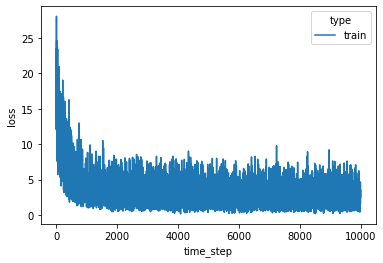

In [23]:
class Model(Net):
    def __init__(self):
        super().__init__()
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.SGD(self.parameters(),
                                         lr=0.001,
                                         momentum=0.9)

    def loss(self, y_prediction, y_real):
        y_real = torch.Tensor(y_real)
        loss = self.criterion(y_prediction, y_real)
        return loss

    def print_params(self, x):
        for param in self.parameters():
            print(param)

    def predict_next_position(self, x):
        return self.forward(x, batch_size=x[0].shape[0])

    def train_on_observations(self):
        entry = []
        data = Data(batch_size=3)
        for step in range(10000):
            X, Y = data.get_batch(mode='train')
            #print(X[0].shape)
            self.optimizer.zero_grad()
            self.hidden = (torch.zeros(1, 1, particles*2),
                           torch.zeros(1, 1, particles*2))

            train_loss = self.loss(self.predict_next_position(X), Y)
            train_loss.backward()
            self.optimizer.step()

            # print(f'step {step}: {train_loss.item()}')
            entry.append({'time_step': step, 'loss': train_loss.item(), 'type': 'train'})

            if step % 10 == 0:
                torch.save({
                    'epoch': step,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': train_loss.item()
                }, saved_path)


        sns.lineplot(data=pd.DataFrame(entry), x='time_step', y='loss', hue='type')


model = Model()
model.train_on_observations()

In [22]:
print(model.predict_next_position(X))
print(Y)

NameError: name 'X' is not defined